파이썬 머신러닝 완벽가이드 ch5. 6 ~ 8 (pg. 337~362)

# 05. 회귀
05-06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
- 규제 선형 모델의 개요
- 릿지 회귀
- 라쏘 회귀
- 엘라스틱넷 회귀
- 선형 회귀 모델을 위한 데이터 변환

05-07. 로지스틱 회귀

05-08. 회귀 트리

---

###**05-06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**

**규제 선형 모델의 개요**
- 문제점: RSS(실제값과 예측값의 차이)를 최소화하는 것만 생각 -->  학습 데이터에 지나치게 맞추는 과적합이 일어나고, 회귀 계수가 쉽게 커짐.

- 새로운 비용(Cost)함수의 목표: RSS(W) + alpha*|W|를 최소화하는 것. (alpha는 비용함수에 부여되는 페널티 값, W는 회귀 계수)
   - alpha=0이면 비용함수는 Min(RSS(W)), RSS 최소화하는데에 초점.
   
     alpha=무한이면 비용함수는 W를 0에 가깝게 최소화해야함. alpha값이 증가할수록 회귀계수 값의 크기가 감소함.  

- 해결: 비용함수에 alpha값으로 페널티를 부여하여 지속적으로 값을 증가시킴으로써 회귀 계수 값의 크기를 감소시켜 과적합을 개선.



**릿지(Ridge) 회귀**

: L2 규제를 적용한 회귀, W의 제곱에 페널티를 부여함.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

# feature name이 없으므로 따로 지정해줘야 함.
feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
bostonDF = pd.DataFrame(boston, columns = feature_names)

In [2]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE : 5.518


In [4]:
# alpha값이 커질수록 5 folds의 평균 RMSE값이 감소함.
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
  ridge = Ridge(alpha = alpha)

  #cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
  print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788
alpha 1 일 때 5 folds의 평균 RMSE : 5.653
alpha 10 일 때 5 folds의 평균 RMSE : 5.518
alpha 100 일 때 5 folds의 평균 RMSE : 5.330


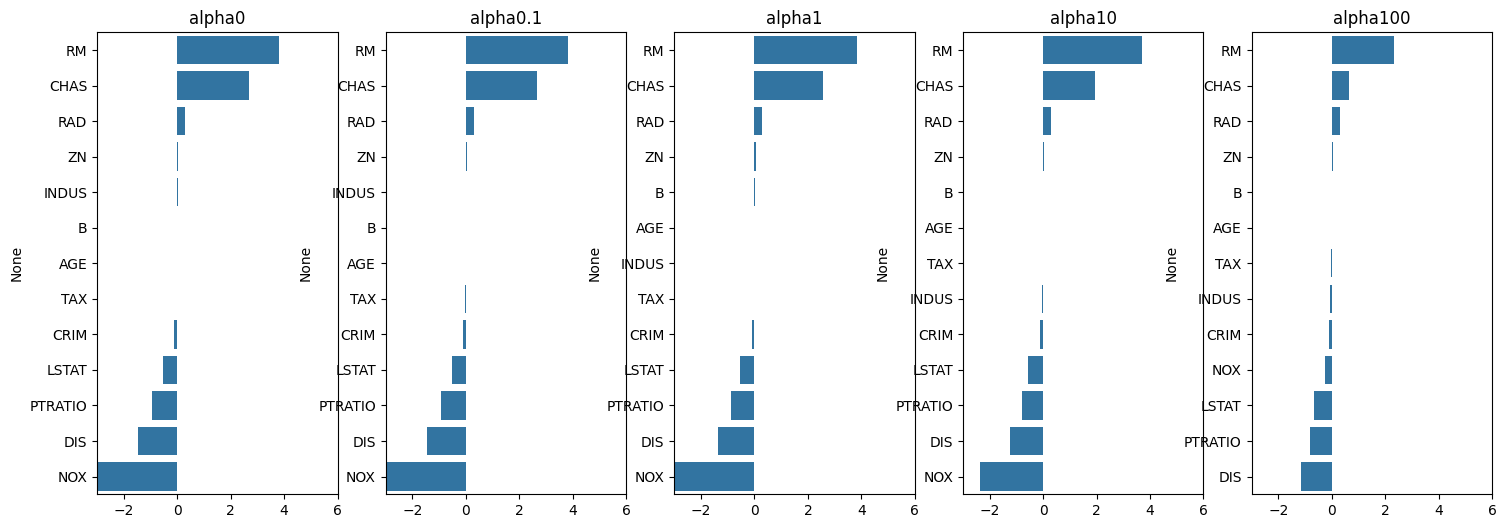

In [6]:
# alpha값을 증가시킬수록 회귀 계수값은 지속적으로 작아짐. 특히, Nox 피처.
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_data, y_target)
  # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
  coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
  colname = 'alpha'+str(alpha)
  coeff_df[colname] = coeff
  # 막대 그래프로 각 alpha값에서의 회귀계수를 시각화. 회귀 계수값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

**라쏘(Lasso) 회귀**

: L1 규제를 적용한 회귀, W의 절댓값에 페널티를 부여함.

L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만듦-> '피처 선택' 규제라고 부름. 피처 선택의 효과를 얻을 수 있음.

In [13]:
# alpha값을 변화시키면서 결과를 출력하기 위한 별도의 함수 get_linear_reg_eval() 생성하기
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

#alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose : print('#######', model_name, '#######')
  for param in params :
    if model_name == 'Ridge' : model = Ridge(alpha=param)
    elif model_name == 'Lasso' : model = Lasso(alpha=param)
    # ElasticNet 객체를 생성할 때 alpha에 따른 변화만을 살피기 위해 l1_ratio는 고정시킴.
    elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5폴그 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
    #cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data_n, y_target_n)
    if return_coeff :
      #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:' + str(param)
      coeff_df[colname] = coeff

  return coeff_df
#end of get_linear_regre_eval

In [14]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval()함수 호출
# alpha값이 증가할수록 평균 RMSE값이 증가함. Lasso의 가장 작은 RMSE값 5.612는 Ridge의 평균 5.518보단 조금 크지만 일반 LinearRegression의 평균인 5.829보다는 향상됨.
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

####### Lasso #######
alpha 0.07일 때 5폴그 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5폴그 세트의 평균 RMSE: 5.669
alpha 1일 때 5폴그 세트의 평균 RMSE: 5.776
alpha 3일 때 5폴그 세트의 평균 RMSE: 6.189


In [15]:
# 반환된 coeff_lasso_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
# alpha의 크기가 증가함에 따라 일부 피처의 회귀계수가 아예 0으로 바뀜. NOX, INDUS, CHAS와 같은 피처.
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


**엘라스틱넷(Elastic Net) 회귀**

: L1 규제와 L2 규제를 결합한 회귀.

서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 선택하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함 (라쏘 회귀).

-->  이러한 성향으로 인해 alpha값에 따라 회귀 계수의 값이 급격히 변동할 수도 있는데, 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가함.
- 두 규제가 결합되어 수행시간이 상대적으로 오래 걸린다는 단점이 있음.
- 규제 = a * L1 + b * L2 (a는 L1 규제의 alpha값, b는 L2 규제의 alpha값)
- ElasticNet 클래스의 l1_ratio 파라미터 = a / (a+b)
   - l1_ratio=0이면 L2 규제와 동일
   - l1_ratio=1이면 L1 규제와 동일

In [16]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정 (오작 alpha값에 따른 변화)
# alpha=0.1일때 평균 RMSE값 최소, 그 후로 증가
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                       X_data_n=X_data, y_target_n=y_target)

####### ElasticNet #######
alpha 0.07일 때 5폴그 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5폴그 세트의 평균 RMSE: 5.467
alpha 1일 때 5폴그 세트의 평균 RMSE: 5.597
alpha 3일 때 5폴그 세트의 평균 RMSE: 6.068


In [17]:
# 반환된 coeff_elastic_df를 첫번째 칼럼 순으로 내림차순 정렬해 회귀계수 DataFrame 출력
# 회귀 계수 값들이 라쏘보다는 상대적으로 0이 되는 값이 적음.
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


**선형 회귀 모델을 위한 데이터 변환**

선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정한 채로 최적의 선형함수를 찾아내어 결괏값을 예측함.
또한, 피처값과 타깃값의 분포가 정규분포인 형태를 매우 선호.
특히, 타깃값의 경우 정규분포 형태가 아닌 skewed된 형태의 분포도일 경우 예측 성능에 큰 부정적인 영향을 끼치기 때문에 선형 모델 적용 전 스케일링/정규화 작업을 진행하는 것이 일반적임.

< 선형 모델 적용 전 스케일링/정규화 방법 >
- 로그 변환(Log Transformation)

   : 가장 많이 사용되는 변환 방법. 특히 타깃값에 적용하면 큰 효과를 봄. np.log( )가 아닌 np.log1p( )를 이용.
- 표준정규분포 변환(StandardScaler) / 최댓값.최솟값 정규화(MinMaxScaler)
   
   : 큰 예측 성능 향상을 기대하긴 어려움.
- 다항변환(Polynomial)
   
   : 피처의 개수가 많을 경우 다항변환 후 너무 많은 피처의 개수로 인해 과적합의 이슈 발생 가능.

In [18]:
# 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그 변환(Log) 중에 하나를 선택하여 적용시키는 함수 생성하기
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p-degree는 다항식 특성을 추가할 때 적용. p-degree는 2 이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None) :
  if method == 'Standard' :
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax' :
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log' :
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data

  if p_degree != None :
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

  return scaled_data

In [20]:
# Ridge의 alpha값(4개)을 다르게 적용하고 다양한 데이터 변환 방법(6개)에 따른 RMSE 추출하기
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 원본, 표준정규분포, 표준정규분포+2차 다항식, 최소.최댓값 정규화, 최소.최댓값 정규화+2차 다항식, 로그변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods :
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 5.788
alpha 1일 때 5폴그 세트의 평균 RMSE: 5.653
alpha 10일 때 5폴그 세트의 평균 RMSE: 5.518
alpha 100일 때 5폴그 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 5.826
alpha 1일 때 5폴그 세트의 평균 RMSE: 5.803
alpha 10일 때 5폴그 세트의 평균 RMSE: 5.637
alpha 100일 때 5폴그 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 8.827
alpha 1일 때 5폴그 세트의 평균 RMSE: 6.871
alpha 10일 때 5폴그 세트의 평균 RMSE: 5.485
alpha 100일 때 5폴그 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 5.764
alpha 1일 때 5폴그 세트의 평균 RMSE: 5.465
alpha 10일 때 5폴그 세트의 평균 RMSE: 5.754
alpha 100일 때 5폴그 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 5.298
alpha 1일 때 5폴그 세트의 평균 RMSE: 4.323
alpha 10일 때 5폴그 세트의 평균 RMSE: 5.185
alpha 100일 때 5폴그 세트의 평균 RMSE: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5폴그 세트의 평균 RMSE: 4.770
alpha 1일 때 5폴그 세트의 평

표준정규분포 변환 후 2차 다항변환했을 때 alpha=100에서 4.634로 개선이 보임. 그 외에 표준정규분포, 최대최소값 변환은 성능상 큰 개선이 없음.

반면, 로그변환했을 때 alpha 0.1, 1, 10의 경우 모두 좋은 성능 향상이 있었음. --> 데이터 분포에 심한 왜곡이 있으면 로그변환을 하자!

###**05-07. 로지스틱 회귀**

선형 회귀 계열 알고리즘. 분류에 이용됨. 가볍고 빠르고 이진 분류 예측 성능도 뛰어남.

선형 회귀와 다른 점은  학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드(Sigmoid) 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 것.

왼쪽의 선형 회귀 라인이 분류를 못하는 건 아니지만 정확도가 떨어짐. 오른쪽과 같이 S자 커브 형태의 시그모이드 함수를 이용하면 더 정확하게 0과 1 분류를 할 수 있음.


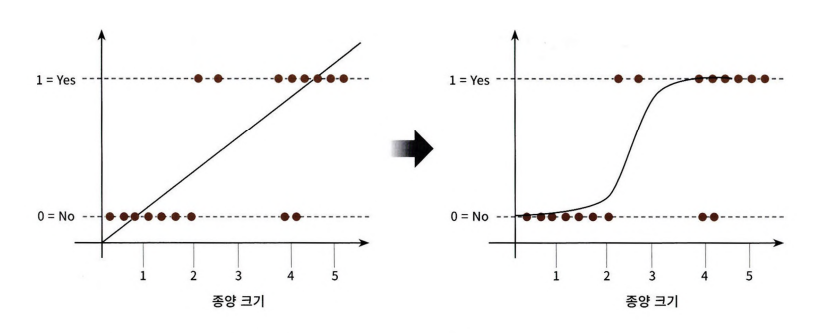

LogisticRegression(solver=________ , penalty=_______ , C=_______)
- solver 파라미터
   - lbfgs: 디폴트, L2 규제만 가능
   - liblinear: L1, L2 규제 모두 가능
   - newton-cg: L2 규제만 가능
   - sag: L2 규제만 가능
   - saga: L1, L2 규제 모두 가능
- penalty 파라미터: 규제유형
    - l2, l1
- C 파라미터: 1/alpha. 작을수록 규제강도가 셈.


일반적으로 lbfgs, liblinear을 선택. liblinear이 좀 더 빠르고 나은 결과를 나타냄.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 예측 성능이 데이터 분포도에 따라 영향을 받을 수 있으므로 StandardScaler()로 평균이 0, 분산이 1인 데이터 분포도로 스케일링
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs' 디폴트
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


**solver별 평가**

In [25]:
# 다른 solver값으로 LogisticRegression 학습 및 평가 수행
# 특정 solver은 최적화에 상대적으로 많은 반복횟수가 필요할 수 있으므로 max_iter값을 600으로 설정
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

for solver in solvers:
  lr_clf = LogisticRegression(solver=solver, max_iter=600)
  lr_clf.fit(X_train, y_train)
  lr_preds = lr_clf.predict(X_test)
  lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

  # accuracy와 roc_auc 측정
  print('solver:{0}, accuracy:{1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds),
                                                               roc_auc_score(y_test, lr_preds_proba)))

solver:lbfgs, accuracy:0.977, roc_auc:0.995
solver:liblinear, accuracy:0.982, roc_auc:0.995
solver:newton-cg, accuracy:0.977, roc_auc:0.995
solver:sag, accuracy:0.982, roc_auc:0.995
solver:saga, accuracy:0.982, roc_auc:0.995


**GridSearchCV를 이용해 solver, penalty, C 최적화**

In [26]:
from sklearn.model_selection import GridSearchCV

params = {'solver':['liblinear', 'lbfgs'],
          'penalty':['l2', 'l1'],
          'C':[0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


###**05-08. 회귀 트리 (Regressor)**

- 선형/비선형 회귀와 같이 회귀 함수를 기반으로 결괏값을 예측하는 것이 아니라, 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측을 하는 것.

- 트리 생성이 CART(Classification and Regression Trees) 알고리즘에 기반. 트리 생성 알고리즘은 분류와 회귀 둘다 가능. 하이퍼파라미터는 동일.

- 사이킷런의 회귀 Estimator 클래스(분류 Estimator 클래스) : DecisionTreeRegressor(DecisionTreeClassifier), GradientBoostingRegressor(GradientBoostingClassifier), XGBRegressor(XGBClassifier), LGBMRegressor(LGBMClassifier)

- 선형 회귀와 다르게 회귀계수를 반환하는 coef_속성이 없음. 대신 feature_importances_로 피처별 중요도 확인 가능.
- 아래와 같이 리프 노드 생성 기준에 부합하는 트리 분할이 완료되었다면 리프 노드에 소속된 데이터의 평균값을 구해서 최종적으로 리프 노드에 결정값으로 할당함.


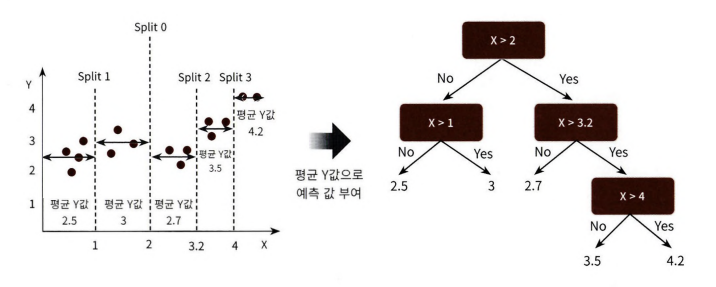

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 보스턴 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])
feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
bostonDF = pd.DataFrame(boston, columns = feature_names)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))


5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [42]:
def get_model_cv_prediction(model, X_data, y_target) :
  neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('#####', model.__class__.__name__, '#####')
  print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models :
  get_model_cv_prediction(model, X_data, y_target)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

<Axes: xlabel='None', ylabel='None'>

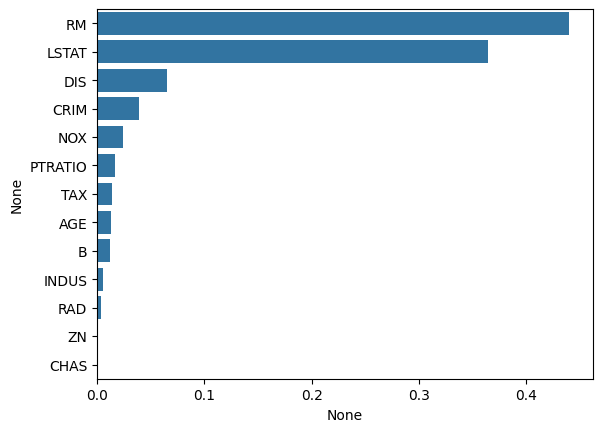

In [31]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_test, y_target 데이터 세트를 적용해 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

**회귀 트리 Regressor이 어떻게 예측값을 판단하는지 선형 회귀와 비교**

(100, 2)


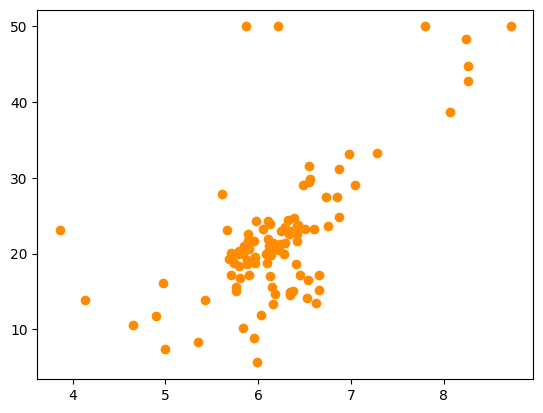

In [32]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)   # 보스터 데이터 세트 100개만 샘플링
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")

In [33]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_dapth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

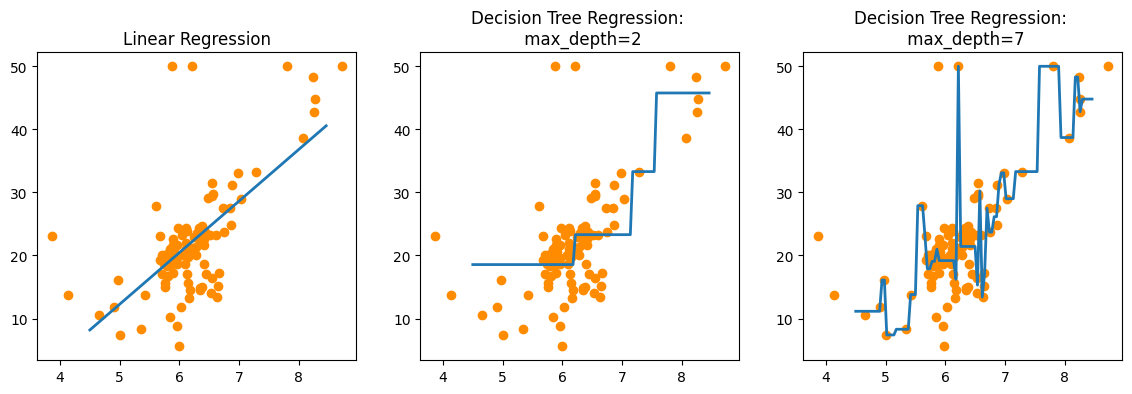

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

# X 축 값을 4.5 ~ 8.5로 변환하며 입력했을 떄 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 떄 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label='max_depth:3', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

plt.show()

회귀 트리는 선형 회귀와 다르게 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만듦. 특히, max_depth=7인 경우 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 쉬운 모델이 되었음을 알 수 있음.